# Model1

## Unzip data

In [ ]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Medical/ADHD_CONTROL/datasets/ADHD_DATA.zip"

## Install packages

In [ ]:
%%capture
! pip install mne

## Gdrive path

In [ ]:
gdrive_Path = "/content/drive/MyDrive/Colab Notebooks/Medical/ADHD_CONTROL"

## Import dependencies

In [ ]:
import mne
import sklearn
import scipy.io
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator

# Spliting by group
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut

# Modeling
from tensorflow.keras.layers import Input,Dense,Flatten,GRU,Conv1D, Concatenate, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf


np.random.seed(42)

## Download helperfunction

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/HSAkash/Attention-Deficit-Disorder-Detection/main/helper_functions.py


"""
Import function from helper_functions.py file
"""
from helper_functions import (
    plot_loss_curves,
    create_tensorboard_callback,
    compare_historys,
    calculate_results,
    bestWeightModelEvaluate,
    getBestWeightModel,
    saveBestWeightModel
)

## History class

In [ ]:
class History:
  
  def __init__(self, history=None):
    self.history = {}
    self.create_history_object(history)

  def create_history_object(self, history):
    if history:
      for his in history.history.keys():
        self.history[his] = history.history[his]
  
  def add_history(self, history):
    if not self.history:
      self.create_history_object(history)
      return
    for his in history.history.keys():
      self.history[his] += history.history[his]

## Mat data mne

### Mat data mne 60 frequency

In [ ]:
mne.set_log_level("WARNING")
def convertmat2mne_60(data):
    ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']
    ch_types = ['eeg'] * 19
    sampling_freq=128
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq, verbose=0)
    info.set_montage('standard_1020', verbose=0)
    data = np.moveaxis(data, 0, -1)
    data=mne.io.RawArray(data, info, verbose=0)
    data.set_eeg_reference(verbose=0)
    epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0, verbose=0)
    return epochs.get_data()

### Mat data mne 1-30 frequency

In [ ]:
def convertmat2mne_30(data):
    ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']
    ch_types = ['eeg'] * 19
    sampling_freq=128
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq, verbose=0)
    info.set_montage('standard_1020', verbose=0)
    data = np.moveaxis(data, 0, -1)
    data=mne.io.RawArray(data, info, verbose=0)
    data.set_eeg_reference(verbose=0)
    data.filter(l_freq=1,h_freq=30)
    epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0, verbose=0)
    # return np.moveaxis(epochs.get_data(), 1, -1)
    return epochs.get_data()

In [ ]:
def get_mne_dataset_60(list_path):
    dataset = []
    for x in tqdm(list_path):
        data = scipy.io.loadmat(x)[x.split('/')[-1].split('.')[0]]
        data = convertmat2mne_60(data)
        dataset.append(data)
    return dataset

def get_mne_dataset_30(list_path):
    dataset = []
    for x in tqdm(list_path):
        data = scipy.io.loadmat(x)[x.split('/')[-1].split('.')[0]]
        data = convertmat2mne_30(data)
        dataset.append(data)
    return dataset

## Get label function

In [ ]:
labels_dict = {"ADHD":1, "Control":0}
def get_label(filePath):
    return labels_dict[filePath.split("/")[-2]]

## Data path

In [ ]:
data_dir = "ADHD_DATA"

## Get all file path

In [ ]:
filePath_list = glob(f"{data_dir}/*/*.mat")
len(filePath_list)

121

## Shuffle filepath list

In [ ]:
filePath_list = sklearn.utils.shuffle(filePath_list, random_state=0)

## Get labels

In [ ]:
labels_list = [get_label(x) for x in filePath_list]
len(labels_list)

121

## get data

In [ ]:
data_list_60 = get_mne_dataset_60(filePath_list)
data_list_30 = get_mne_dataset_30(filePath_list)
np.shape(data_list_60), np.shape(data_list_30)

100%|██████████| 121/121 [00:15<00:00,  7.68it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


((121,), (121,))

## Get labels 

In [ ]:
label_list, groups_list = [], []
for i, data in enumerate(data_list_60):
    label_list.append([labels_list[i]]*len(data))
    groups_list.append([i]*len(data))

## List to numpy

In [ ]:
data_array_60=np.concatenate(data_list_60)
data_array_30=np.concatenate(data_list_30)
label_array=np.concatenate(label_list)
group_array=np.concatenate(groups_list)

data_array_60=np.moveaxis(data_array_60,1,2)
data_array_30=np.moveaxis(data_array_30,1,2)

del(data_list_60)
del(data_list_30)
del(label_list)
del(groups_list)

data_array_60.shape, data_array_30.shape

((4173, 512, 19), (4173, 512, 19))

## Scaling

In [ ]:
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()
        # self.scaler = MinMaxScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

## Spliting data by group and scaling

In [ ]:
gkf=GroupKFold()
for train_index, val_index in gkf.split(data_array_60, label_array, groups=group_array):

    train_features_60,train_labels=data_array_60[train_index],label_array[train_index]
    val_features_60,val_labels=data_array_60[val_index],label_array[val_index]

    scaler_60=StandardScaler3D()
    train_features_60=scaler_60.fit_transform(train_features_60)
    val_features_60=scaler_60.transform(val_features_60)


    train_features_30=data_array_30[train_index]
    val_features_30=data_array_30[val_index]

    scaler_30=StandardScaler3D()
    train_features_30=scaler_30.fit_transform(train_features_30)
    val_features_30=scaler_30.transform(val_features_30)


    break

## Create model1

In [ ]:
tf.random.set_seed(42)

### Create  check points

In [ ]:
checkpoint_path = f"{gdrive_Path}/14_crononet/10/checkpoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)
tensorboard_dir = f"{gdrive_Path}/14_crononet/10/tensorboard"
tensorboard_name = 'ADHD_model'
checkpoint_path

'checkpoint/cp.ckpt'

### Modeling

In [ ]:
def block(input):
  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=-1)
  return x

#### Model part1

In [ ]:
input_60= Input(shape=train_features_60.shape[1:])
block1_60=block(input_60)
block2_60=block(block1_60)
block3_60=block(block2_60)
gru_out1_60 = GRU(32,activation='tanh',return_sequences=True)(block3_60)
gru_out2_60 = GRU(32,activation='tanh',return_sequences=True)(gru_out1_60)
gru_out_60 = concatenate([gru_out1_60,gru_out2_60],axis=-1)
gru_out3_60 = GRU(32,activation='tanh',return_sequences=True)(gru_out_60)
gru_out_60 = concatenate([gru_out1_60,gru_out2_60,gru_out3_60])
gru_out4_60 = GRU(32,activation='tanh')(gru_out_60)
gru_out4_60.shape

TensorShape([None, 32])

#### Model part2

In [ ]:
input_30= Input(shape=train_features_30.shape[1:])
block1_30=block(input_30)
block2_30=block(block1_30)
block3_30=block(block2_30)
gru_out1_30 = GRU(32,activation='tanh',return_sequences=True)(block3_30)
gru_out2_30 = GRU(32,activation='tanh',return_sequences=True)(gru_out1_30)
gru_out_30 = concatenate([gru_out1_30,gru_out2_30],axis=-1)
gru_out3_30 = GRU(32,activation='tanh',return_sequences=True)(gru_out_30)
gru_out_30 = concatenate([gru_out1_30,gru_out2_30,gru_out3_30])
gru_out4_30 = GRU(32,activation='tanh')(gru_out_30)
gru_out4_30.shape

TensorShape([None, 32])

#### Combine two model

In [ ]:
combine = concatenate([gru_out4_60,gru_out4_30])
combine.shape

TensorShape([None, 64])

In [ ]:
output = Dense(1,activation='sigmoid')(combine)
model = Model(inputs=[input_60, input_30], outputs=output)

#### Compile model

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### Summary model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 19)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512, 19)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 32)      1248        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 256, 32)      2464        ['input_1[0][0]']                
                                                                                              

### Ploting model

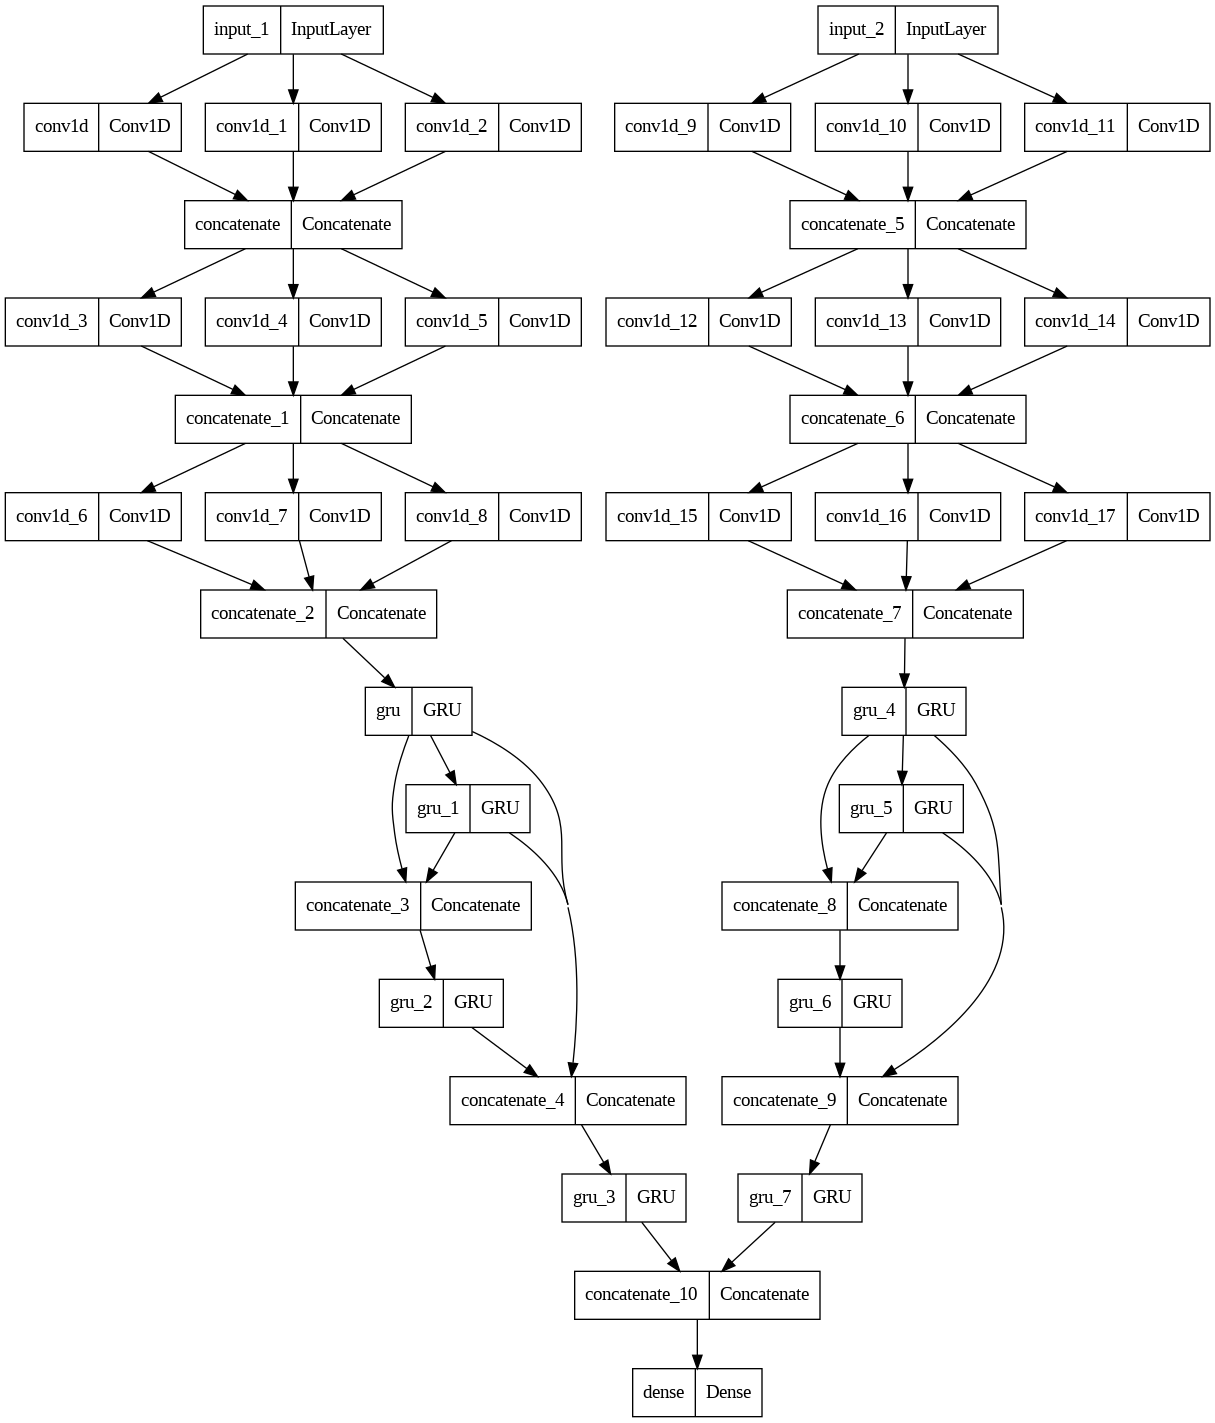

In [ ]:
tf.keras.utils.plot_model(model)

### Fit the model epoch 10

In [ ]:
history = model.fit(
    [train_features_60, train_features_30],
    train_labels,
    validation_data = ([val_features_60, val_features_30], val_labels),
    epochs=10,
    batch_size=128,
    callbacks = [
        create_tensorboard_callback(
            dir_name = tensorboard_dir,
            experiment_name = tensorboard_name
        ),
        checkpoint_callback
    ]
)
histories = History(history)

Saving TensorBoard log files to: tensorboard/ADHD_model/20230330-060348
Epoch 1/10
27/27 [==============================] - 64s 1s/step - loss: 0.6521 - accuracy: 0.6157 - val_loss: 0.5890 - val_accuracy: 0.7163
Epoch 2/10
27/27 [==============================] - 35s 1s/step - loss: 0.3803 - accuracy: 0.8399 - val_loss: 0.3388 - val_accuracy: 0.8522
Epoch 3/10
27/27 [==============================] - 33s 1s/step - loss: 0.1936 - accuracy: 0.9267 - val_loss: 0.1686 - val_accuracy: 0.9267
Epoch 4/10
27/27 [==============================] - 34s 1s/step - loss: 0.0970 - accuracy: 0.9665 - val_loss: 0.3338 - val_accuracy: 0.8678
Epoch 5/10
27/27 [==============================] - 34s 1s/step - loss: 0.0255 - accuracy: 0.9946 - val_loss: 0.3295 - val_accuracy: 0.8894
Epoch 6/10
27/27 [==============================] - 36s 1s/step - loss: 0.0121 - accuracy: 0.9973 - val_loss: 0.5338 - val_accuracy: 0.8606
Epoch 7/10
27/27 [==============================] - 36s 1s/step - loss: 0.0077 - accurac

### Plot model loss curves

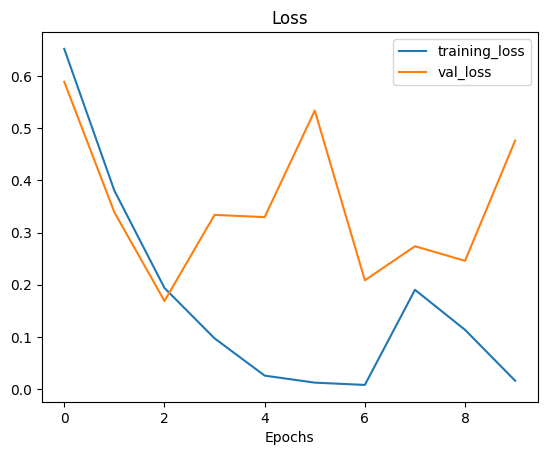

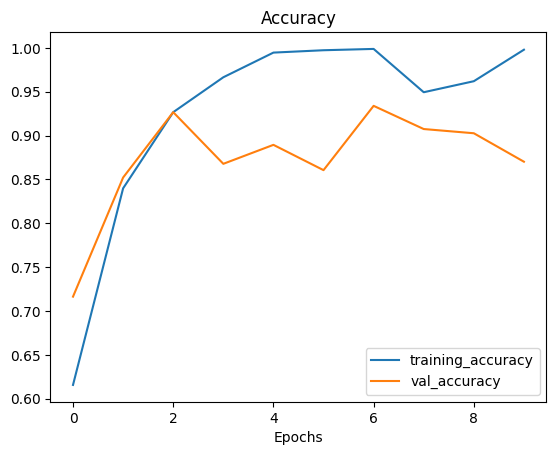

In [ ]:
plot_loss_curves(histories)

### Evaluate

#### Evaluate model

In [ ]:
model.evaluate([val_features_60, val_features_30], val_labels)

26/26 [==============================] - 4s 146ms/step - loss: 0.4764 - accuracy: 0.8702


[0.4763686954975128, 0.870192289352417]

#### Copy Model and load best weight

In [ ]:
best_model = tf.keras.models.clone_model(model)
best_model.load_weights(checkpoint_path)
best_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

#### Evalute best model

In [ ]:
best_model.evaluate([train_features_60, train_features_30], train_labels), best_model.evaluate([val_features_60, val_features_30], val_labels)

26/26 [==============================] - 2s 85ms/step - loss: 0.2083 - accuracy: 0.9339


([0.024994324892759323, 0.9907213449478149],
 [0.2082936018705368, 0.9338942170143127])

### Confusion matrix

#### Confusion matrix function

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, title="Confusion Matrix Valid Data",figsize=(10, 10), text_size=15, norm=False): 
  for x, y in enumerate(classes):
      classes[x] = y.replace("Potato___",'')
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title=title,
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
#   ax.tick_params(axis='x', labelrotation=45)
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
  fig.savefig(f"{title}.png")
      

#### Prediction

#### Val data conf matrix

In [ ]:
val_y_pred = best_model.predict([val_features_60, val_features_30], verbose=0)

In [ ]:
val_y_pred = np.squeeze(np.where(val_y_pred >= 0.5, 1, 0), axis=-1)

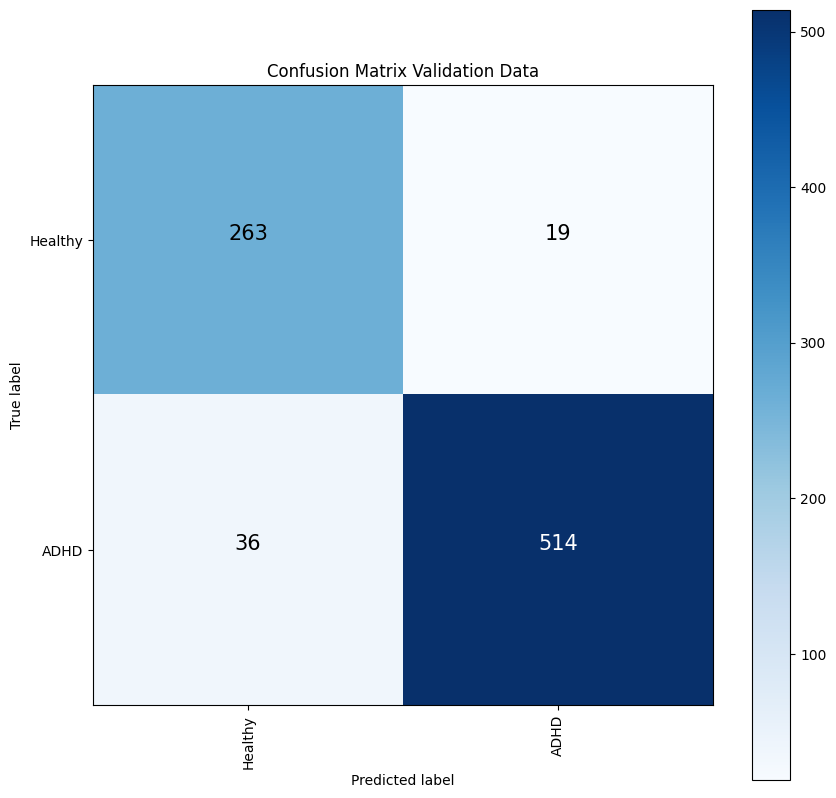

In [ ]:
make_confusion_matrix(val_labels, val_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix Validation Data")

#### train data conf matrix

In [ ]:
train_y_pred = best_model.predict([train_features_60, train_features_30], verbose=0)
train_y_pred = np.squeeze(np.where(train_y_pred >= 0.5, 1, 0), axis=-1)

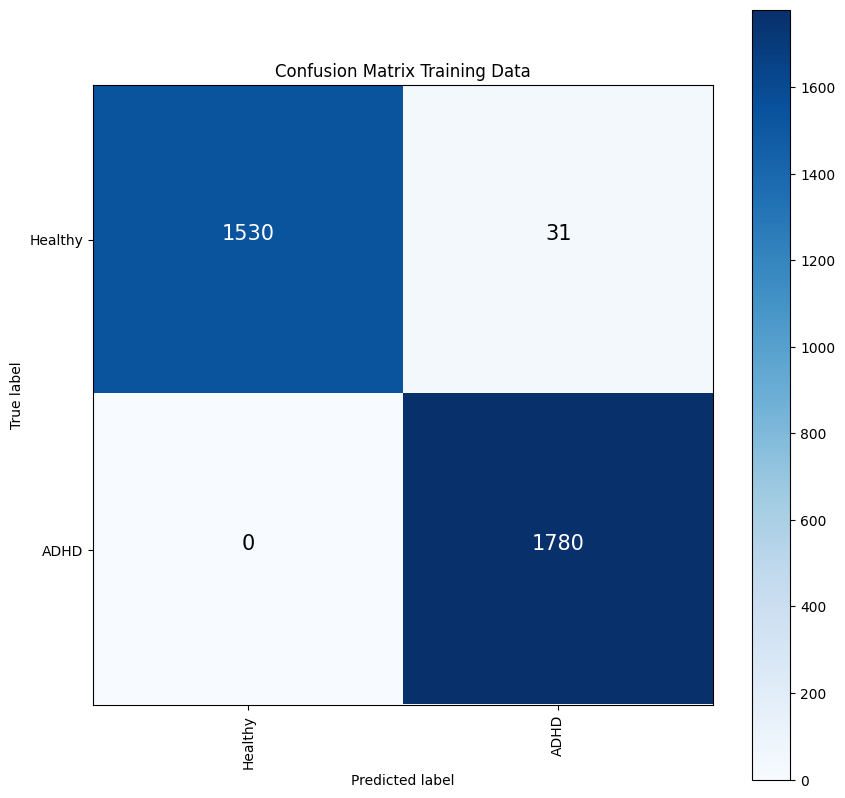

In [ ]:
make_confusion_matrix(train_labels, train_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix Training Data")

#### Full data conf matrix

In [ ]:
full_data_60 = np.concatenate([train_features_60, val_features_60], axis=0)
full_data_30 = np.concatenate([train_features_30, val_features_30], axis=0)
full_label = np.concatenate([train_labels, val_labels])

In [ ]:
full_y_pred = best_model.predict([full_data_60, full_data_30], verbose=0)
full_y_pred = np.squeeze(np.where(full_y_pred >= 0.5, 1, 0), axis=-1)

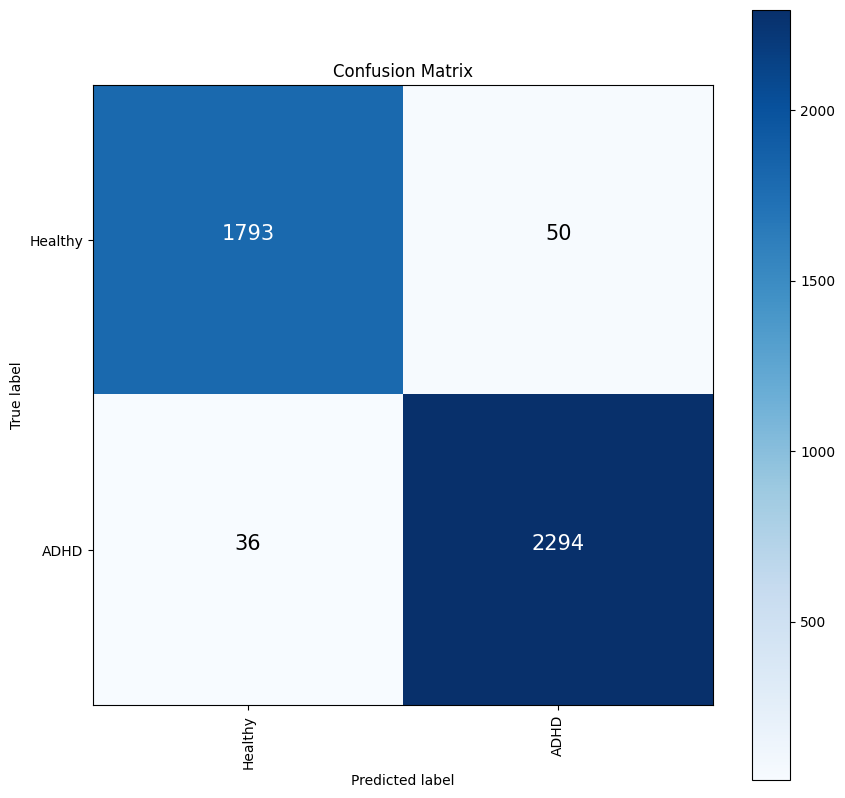

In [ ]:
make_confusion_matrix(full_label, full_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix")

### Save best model

In [ ]:
best_model.save(f"{gdrive_Path}/model/0.h5")